# Authentication Establishment

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.8MB/s 


# Import Data

In [0]:
!mkdir ~/.kaggle
!echo '{"username":"abhiksark","key":"xx"}' > ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c diabetic-retinopathy-detection -p datalab

  0% 0.00/69.4k [00:00<?, ?B/s]
100% 69.4k/69.4k [00:00<00:00, 59.1MB/s]
  0% 0.00/81.6k [00:00<?, ?B/s]
100% 81.6k/81.6k [00:00<00:00, 85.0MB/s]
 48% 5.00M/10.4M [00:00<00:00, 19.5MB/s]
100% 10.4M/10.4M [00:00<00:00, 34.6MB/s]
100% 7.81G/7.81G [00:57<00:00, 110MB/s]
100% 7.81G/7.81G [00:57<00:00, 147MB/s]
100% 7.80G/7.81G [00:56<00:00, 175MB/s]
100% 7.81G/7.81G [00:57<00:00, 147MB/s]
100% 7.80G/7.81G [00:57<00:00, 166MB/s]
100% 7.81G/7.81G [00:57<00:00, 146MB/s]
100% 1.33G/1.34G [00:08<00:00, 175MB/s]
100% 1.34G/1.34G [00:08<00:00, 160MB/s]
100% 7.81G/7.81G [00:57<00:00, 180MB/s]
100% 7.81G/7.81G [00:57<00:00, 146MB/s]
100% 7.81G/7.81G [02:17<00:00, 72.7MB/s]
100% 7.81G/7.81G [02:17<00:00, 60.9MB/s]
100% 7.80G/7.81G [02:15<00:00, 60.1MB/s]
100% 7.81G/7.81G [02:15<00:00, 61.9MB/s]
100% 7.80G/7.81G [02:17<00:00, 82.2MB/s]
100% 7.81G/7.81G [02:17<00:00, 61.0MB/s]
100% 7.80G/7.81G [02:37<00:00, 51.3MB/s]
100% 7.81G/7.81G [02:37<00:00, 53.2MB/s]
100% 7.80G/7.81G [02:25<00:00, 46.5MB/s]
100

In [0]:
#using capture to mute the outputs
%%capture
!7z x datalab/test.zip.001
!7z x datalab/train.zip.001
!unzip datalab/trainLabels.csv.zip

In [0]:
#transfering test and train to tmp folder
!mkdir tmp
!mv test tmp
!mv train tmp

# Pre-Processing

In [0]:
#imports 
import pandas as pd
import os
import random
import os
import math
import numpy as np

from PIL import Image
from skimage import io
from skimage import exposure


In [0]:
trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [0]:
listing = os.listdir("tmp/train") 

In [0]:
!mkdir tmp/train/0
!mkdir tmp/train/1
!mkdir tmp/train/2
!mkdir tmp/train/3
!mkdir tmp/train/4


In [ ]:
base_dir = "tmp/train/"

for file in listing:
    try:
        fileName = os.path.splitext(file)[0]
        folder_name = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]  
        os.rename(base_dir + file, base_dir + str(folder_name) + "/" + file )
    except:
        print("error")
        pass

In [0]:
!ls tmp/train/0 | wc -l

25810


In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
from imutils import paths
import cv2

%matplotlib inline

In [0]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [0]:
def blur_check(PATH): 
    image_dict = {}
    list_of_images = os.listdir(PATH)
    for im in list_of_images:
        image = cv2.imread(PATH+im)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fm = variance_of_laplacian(gray)
        #plt.imshow(image);
        #plt.show()
        image_dict[im]= fm 
    return image_dict

In [ ]:
def resize(PATH):
    images = os.listdir(PATH);
    for image in images:
        name = PATH + image
        im = cv2.imread(name)
        im = cv2.resize (im, (512, 512));
        cv2.imwrite(name, im)

In [ ]:
def remove_blur_images(BASE_DIR,to_delete):
    for file in to_delete:
        os.remove(BASE_DIR+file)

In [ ]:
def data_aug_val(path):
    listing_test = os.listdir(path)
    for file_name in listing_test:
            image = io.imread(path+file_name)
            v_min, v_max = np.percentile(image, (0.2, 99.8))
            better_contrast = exposure.rescale_intensity(image, in_range=(v_min, v_max))
            log_correction_image = exposure.adjust_log(image)
            sigmoid_correction_image = exposure.adjust_sigmoid(image)
            horizontal_flip = image[:, ::-1]
            #color_inversion_image_with_np = np.invert(image)
            #adjusted_gamma_image = exposure.adjust_gamma(image, gamma=0.4, gain=0.9)
            io.imsave(path+str(1)+file_name,better_contrast)
            io.imsave(path+str(2)+file_name,log_correction_image)
            io.imsave(path+str(3)+file_name,sigmoid_correction_image)

In [ ]:
def remove_excess_images(PATH,number):
    listing = os.listdir(PATH) 
    to_delete = random.sample(listing, number)
    for file in to_delete:
        os.remove(PATH+file)

In [ ]:
def data_aug_val_1(path):
    listing_test = os.listdir(path)
    for file_name in listing_test:
            image = io.imread(path+file_name)
            log_correction_image = exposure.adjust_log(image)
            #color_inversion_image_with_np = np.invert(image)
            #adjusted_gamma_image = exposure.adjust_gamma(image, gamma=0.4, gain=0.9)
            #io.imsave(path+str(1)+file_name,better_contrast)
            io.imsave(path+str(2)+file_name,log_correction_image)
            #io.imsave(path+str(3)+file_name,sigmoid_correction_image)

In [0]:
%time resize("tmp/train/0/")
%time resize("tmp/train/1/")
%time resize("tmp/train/2/")
%time resize("tmp/train/3/")
%time resize("tmp/train/4/")

CPU times: user 39min 41s, sys: 1min 44s, total: 41min 26s
Wall time: 40min 25s
CPU times: user 39min 41s, sys: 1min 44s, total: 41min 26s
Wall time: 40min 25s
CPU times: user 3min 43s, sys: 10.1 s, total: 3min 53s
Wall time: 3min 47s
CPU times: user 3min 43s, sys: 10.1 s, total: 3min 53s
Wall time: 3min 47s
CPU times: user 8min 25s, sys: 22.6 s, total: 8min 47s
Wall time: 8min 34s
CPU times: user 8min 25s, sys: 22.6 s, total: 8min 47s
Wall time: 8min 34s
CPU times: user 1min 24s, sys: 3.61 s, total: 1min 28s
Wall time: 1min 26s
CPU times: user 1min 24s, sys: 3.61 s, total: 1min 28s
Wall time: 1min 26s
CPU times: user 1min 9s, sys: 2.96 s, total: 1min 12s
Wall time: 1min 10s
CPU times: user 1min 9s, sys: 2.96 s, total: 1min 12s
Wall time: 1min 10s


In [0]:
%time dict_sharp = blur_check("./tmp/train/0/")

CPU times: user 3min 34s, sys: 25.3 s, total: 4min
Wall time: 3min 34s
CPU times: user 3min 34s, sys: 25.3 s, total: 4min
Wall time: 3min 34s


In [0]:
#creating a dataframe of val and image name 
val_series = pd.Series(dict_sharp)
df = pd.DataFrame(val_series,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [0]:
df.head(3000).tail(10)

,index,val
2990,23233_left.jpeg,29.951339
2991,13042_left.jpeg,29.955024
2992,38243_right.jpeg,29.963623
2993,41312_left.jpeg,29.971027
2994,20316_left.jpeg,29.976616
2995,13196_right.jpeg,29.979807
2996,33159_left.jpeg,29.982596
2997,38162_left.jpeg,29.989548
2998,43225_right.jpeg,29.992973
2999,14933_right.jpeg,29.996082


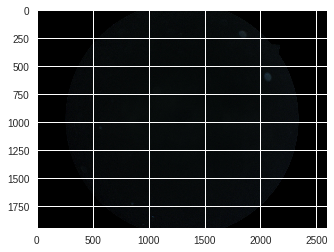

In [0]:
#checking the image having the lowest val
image = cv2.imread("./tmp/train/0/27481_right.jpeg")
plt.imshow(image);
plt.show()

In [0]:
to_delete = df["index"].head(3000).tolist()
remove_blur_images("./tmp/train/0/",to_delete)

In [0]:
!ls tmp/train/0 | wc -l

22810


In [0]:
%time dict_sharp = blur_check("./tmp/train/1/")

CPU times: user 20.3 s, sys: 3.23 s, total: 23.6 s
Wall time: 21.1 s


In [0]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [0]:
df.head(100).tail()

,index,val
95,13043_right.jpeg,23.295280
96,30205_left.jpeg,23.316267
97,393_right.jpeg,23.355272
98,41105_right.jpeg,23.369600
99,39832_left.jpeg,23.531645


In [0]:
to_delete = df["index"].head(100).tolist()

In [0]:
remove_blur_images("./tmp/train/1/",to_delete)

In [0]:
!ls tmp/train/1 | wc -l

2343


In [0]:
%time dict_sharp = blur_check("./tmp/train/2/")

CPU times: user 43.5 s, sys: 6.05 s, total: 49.5 s
Wall time: 43.2 s


In [0]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [0]:
df.head(250).tail()

,index,val
245,21447_right.jpeg,18.958998
246,33746_right.jpeg,18.960989
247,30069_left.jpeg,18.976494
248,9942_right.jpeg,18.976888
249,2357_left.jpeg,19.053912


In [0]:
to_delete = df["index"].head(250).tolist()

In [0]:
remove_blur_images("./tmp/train/2/",to_delete)

In [0]:
%time dict_sharp = blur_check("./tmp/train/3/")

CPU times: user 7.25 s, sys: 983 ms, total: 8.23 s
Wall time: 7.19 s


In [0]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [0]:
df.head(40).tail()

,index,val
35,8699_left.jpeg,16.152079
36,40259_left.jpeg,17.012925
37,5298_right.jpeg,17.035852
38,18971_left.jpeg,17.069210
39,34006_right.jpeg,17.433434


In [0]:
to_delete = df["index"].head(40).tolist()

In [0]:
remove_blur_images("./tmp/train/3/",to_delete)

In [0]:
%time dict_sharp = blur_check("./tmp/train/4/")

CPU times: user 5.92 s, sys: 776 ms, total: 6.69 s
Wall time: 5.84 s


In [0]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [0]:
df.head(30)

,index,val
0,30723_left.jpeg,4.110168
1,40178_left.jpeg,5.632523
2,30675_left.jpeg,7.969081
3,6613_right.jpeg,8.131547
4,41852_right.jpeg,8.718414
5,17411_right.jpeg,9.154816
6,35704_left.jpeg,9.200000
7,31659_right.jpeg,9.372860
8,40819_left.jpeg,10.066191
9,9298_right.jpeg,10.068080


In [0]:
to_delete = df["index"].head(30).tolist()

In [0]:
remove_blur_images("./tmp/train/4/",to_delete)

In [0]:
!ls tmp/train/0 | wc -l

22810


In [0]:
!ls tmp/train/1 | wc -l

2343


In [0]:
!ls tmp/train/2 | wc -l

5042


In [0]:
!ls tmp/train/3 | wc -l

833


In [0]:
!ls tmp/train/4 | wc -l

678


In [0]:
remove_excess_images("tmp/train/0/",14000)

In [0]:
!ls tmp/train/0 | wc -l

8810


In [0]:
data_aug_val_1("tmp/train/1/")

In [0]:
data_aug_val("tmp/train/3/")
data_aug_val("tmp/train/4/")

In [ ]:
#creating a zip file containing all the train images
#using capture to mute the outputs
%%capture
!zip -r tmp/train{.zip,}

In [0]:
#uploading the zip created

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# 2. Save Keras Model or weights on google drive

# create on Colab directory
  
model_file = drive.CreateFile({'title' : 'train.zip'})
model_file.SetContentFile('./tmp/train.zip')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})


GoogleDriveFile({'id': '12pmf7HcIoXtDNw7jXwUnqv6eXAG-zkjA'})